In [1]:
import warnings

warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy
import cmocean

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

2023-02-28 12:17:16.755572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 12:17:18.797617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/5.4.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-02-28 12:17:18.797655: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore

In [2]:
# Declare variables

batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch

num_classes = 10 #
class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
epochs = 100 # repeat 100 times

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

classes_train = np.array([class_names[y[0]] for y in y_train])
classes_train = classes_train[:,np.newaxis]
classes_test = np.array([class_names[y[0]] for y in y_test])
classes_test = classes_test[:,np.newaxis]

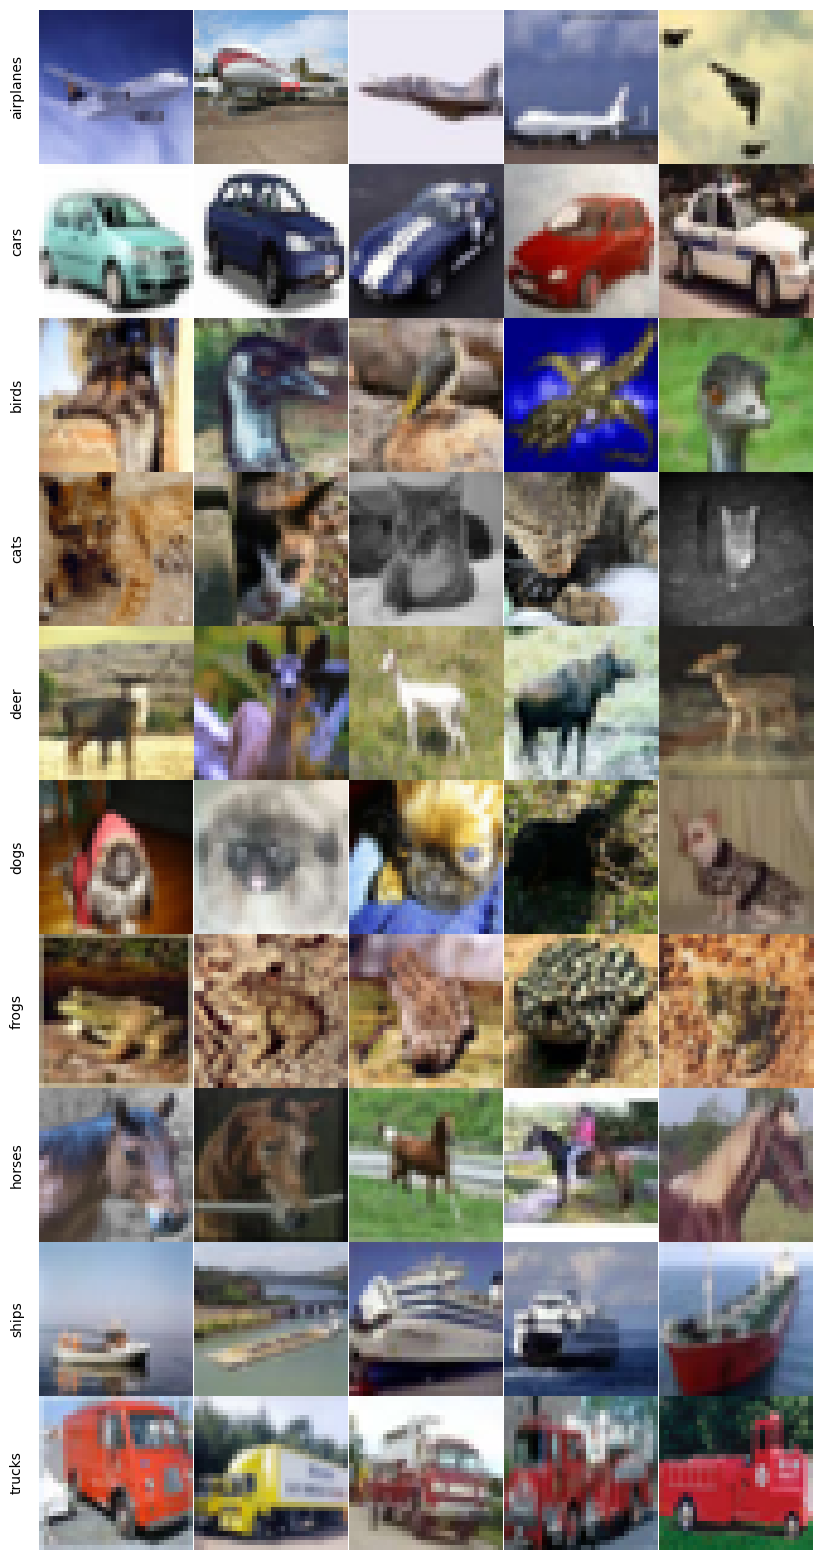

In [4]:
plot_cols = 5
plot_rows = num_classes

plt.rcParams['figure.figsize'] = [10, 20]
fig, ax = plt.subplots(plot_rows,plot_cols)
fig.subplots_adjust(hspace=0, wspace=0)

for i in range(plot_rows):

    class_samples = x_train[np.squeeze(y_train)==i]
    shuffled_indices = np.arange(class_samples.shape[0])
    np.random.shuffle(shuffled_indices)
    plot_samples = class_samples[shuffled_indices[:plot_cols]]

    for j in range(plot_cols):
        
        ax[i, j].imshow(plot_samples[j])
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].tick_params(left=False)
        ax[i, j].tick_params(bottom=False)
        if j == 0:
            ax[i, j].set_ylabel(class_names[i])
            ### Remove borders
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(False)
            ax[i, j].spines['left'].set_visible(False)
        else:
            ax[i, j].axis('off')
        
plt.show()

In [5]:
x_train_nom = x_train.astype(np.float) / 255.0
x_test_nom  = x_test.astype(np.float) / 255.0
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)

In [6]:
keras.backend.clear_session()

inputs = Input(shape=(32,32,3))
conv2d1 = Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
dropout = Dropout(0.2)
conv2d2 = Conv2D(filters=64,kernel_size=(4,4),input_shape=(14,14,32),activation='relu', kernel_regularizer=l2(0.001))
flatten = Flatten()
dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))
dense2 = Dense(10, activation='softmax')

x = conv2d1(inputs)
print(x.shape)
x = maxpool2d(x)
x = dropout(x)
print(x.shape)
x = conv2d2(x)
print(x.shape)
x = maxpool2d(x)
x = dropout(x)
print(x.shape)
x = flatten(x)
print(x.shape)
x = dense1(x)
x = dropout(x)
print(x.shape)
x = dense2(x)
print(x.shape)

model1 = keras.Model(inputs=inputs, outputs=x) 

mod_h5_1 = 'CIFAR10_model_1.h5'

checkpoint = ModelCheckpoint(mod_h5_1, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model1.compile(optimizer='adam',
            loss='categorical_crossentropy', metrics=['acc'])
fit1 = model1.fit(x_train_nom, y_train_onehot,
            batch_size=1000,
            epochs=100, 
            shuffle=True,
            validation_split = 0.1, 
            callbacks=callbacks)  

(None, 29, 29, 32)
(None, 14, 14, 32)
(None, 11, 11, 64)
(None, 5, 5, 64)
(None, 1600)
(None, 256)
(None, 10)


2023-02-28 12:17:53.017323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/5.4.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-02-28 12:17:53.017549: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-28 12:17:53.017583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c2-1): /proc/driver/nvidia/version does not exist


Train on 45000 samples, validate on 5000 samples


2023-02-28 12:17:53.819788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 12:17:53.873242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Epoch 1/100


2023-02-28 12:17:54.110580: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/conv2d_1/bias/v/Assign' id:437 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_1/bias/v, training/Adam/conv2d_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


45000/45000 [==============================] - ETA: 0s - loss: 2.2964 - acc: 0.2796

2023-02-28 12:18:02.016263: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/AddN_1' id:233 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_loss improved from inf to 1.92860, saving model to CIFAR10_model_1.h5
45000/45000 [==============================] - 8s 185us/sample - loss: 2.2964 - acc: 0.2796 - val_loss: 1.9286 - val_acc: 0.3878
Epoch 2/100
45000/45000 [==============================] - ETA: 0s - loss: 1.8340 - acc: 0.4080
Epoch 2: val_loss improved from 1.92860 to 1.72531, saving model to CIFAR10_model_1.h5
45000/45000 [==============================] - 8s 173us/sample - loss: 1.8340 - acc: 0.4080 - val_loss: 1.7253 - val_acc: 0.4420
Epoch 3/100
45000/45000 [==============================] - ETA: 0s - loss: 1.6728 - acc: 0.4528
Epoch 3: val_loss improved from 1.72531 to 1.58535, saving model to CIFAR10_model_1.h5
45000/45000 [==============================] - 8s 175us/sample - loss: 1.6728 - acc: 0.4528 - val_loss: 1.5853 - val_acc: 0.4972
Epoch 4/100
45000/45000 [==============================] - ETA: 0s - loss: 1.5839 - acc: 0.4846
Epoch 4: val_loss improved from 1.58535 to 1.51486, saving model to

45000/45000 [==============================] - 8s 174us/sample - loss: 1.0875 - acc: 0.6762 - val_loss: 1.0515 - val_acc: 0.6998
Epoch 29/100
45000/45000 [==============================] - ETA: 0s - loss: 1.0765 - acc: 0.6822
Epoch 29: val_loss did not improve from 1.05148
45000/45000 [==============================] - 8s 184us/sample - loss: 1.0765 - acc: 0.6822 - val_loss: 1.0600 - val_acc: 0.6984
Epoch 30/100
45000/45000 [==============================] - ETA: 0s - loss: 1.0741 - acc: 0.6840
Epoch 30: val_loss improved from 1.05148 to 1.04646, saving model to CIFAR10_model_1.h5
45000/45000 [==============================] - 8s 175us/sample - loss: 1.0741 - acc: 0.6840 - val_loss: 1.0465 - val_acc: 0.7046
Epoch 31/100
45000/45000 [==============================] - ETA: 0s - loss: 1.0700 - acc: 0.6852
Epoch 31: val_loss did not improve from 1.04646
45000/45000 [==============================] - 8s 171us/sample - loss: 1.0700 - acc: 0.6852 - val_loss: 1.0523 - val_acc: 0.6976
Epoch 32/

Epoch 57/100
45000/45000 [==============================] - ETA: 0s - loss: 0.9185 - acc: 0.7523
Epoch 57: val_loss did not improve from 0.96114
45000/45000 [==============================] - 8s 173us/sample - loss: 0.9185 - acc: 0.7523 - val_loss: 0.9659 - val_acc: 0.7332
Epoch 58/100
45000/45000 [==============================] - ETA: 0s - loss: 0.9091 - acc: 0.7544
Epoch 58: val_loss did not improve from 0.96114
45000/45000 [==============================] - 8s 171us/sample - loss: 0.9091 - acc: 0.7544 - val_loss: 0.9669 - val_acc: 0.7432
Epoch 59/100
45000/45000 [==============================] - ETA: 0s - loss: 0.9038 - acc: 0.7570
Epoch 59: val_loss did not improve from 0.96114
45000/45000 [==============================] - 8s 172us/sample - loss: 0.9038 - acc: 0.7570 - val_loss: 0.9747 - val_acc: 0.7360
Epoch 60/100
45000/45000 [==============================] - ETA: 0s - loss: 0.8983 - acc: 0.7598
Epoch 60: val_loss improved from 0.96114 to 0.95002, saving model to CIFAR10_mode

45000/45000 [==============================] - ETA: 0s - loss: 0.8135 - acc: 0.7960
Epoch 86: val_loss did not improve from 0.93334
45000/45000 [==============================] - 8s 172us/sample - loss: 0.8135 - acc: 0.7960 - val_loss: 0.9418 - val_acc: 0.7574
Epoch 87/100
45000/45000 [==============================] - ETA: 0s - loss: 0.8098 - acc: 0.7988
Epoch 87: val_loss did not improve from 0.93334
45000/45000 [==============================] - 8s 171us/sample - loss: 0.8098 - acc: 0.7988 - val_loss: 0.9439 - val_acc: 0.7616
Epoch 88/100
45000/45000 [==============================] - ETA: 0s - loss: 0.8113 - acc: 0.7958
Epoch 88: val_loss did not improve from 0.93334
45000/45000 [==============================] - 8s 171us/sample - loss: 0.8113 - acc: 0.7958 - val_loss: 0.9420 - val_acc: 0.7552
Epoch 89/100
45000/45000 [==============================] - ETA: 0s - loss: 0.8131 - acc: 0.7977
Epoch 89: val_loss did not improve from 0.93334
45000/45000 [==============================] -

In [7]:
keras.backend.clear_session()

inputs = Input(shape=(32,32,3))
conv2d1 = Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
dropout = Dropout(0.2)
conv2d2 = Conv2D(filters=64,kernel_size=(4,4),input_shape=(14,14,32),activation='relu', kernel_regularizer=l2(0.001))
flatten = Flatten()
dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))
dense2 = Dense(10, activation='softmax')

x = conv2d1(inputs)
x = maxpool2d(x)
x = dropout(x)
x = conv2d2(x)
x = maxpool2d(x)
x = dropout(x)
x = flatten(x)
x = dense1(x)
x = dropout(x)
x = dense2(x)

best_model1 = keras.Model(inputs=inputs, outputs=x) 
best_model1.load_weights(mod_h5_1)
best_model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

y_test_pred1 = best_model1.predict(x_test_nom)

2023-02-28 12:30:55.044880: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1/bias/Assign' id:125 op device:{requested: '', assigned: ''} def:{{{node dense_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1/bias, dense_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:30:55.198667: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1/Softmax' id:131 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-

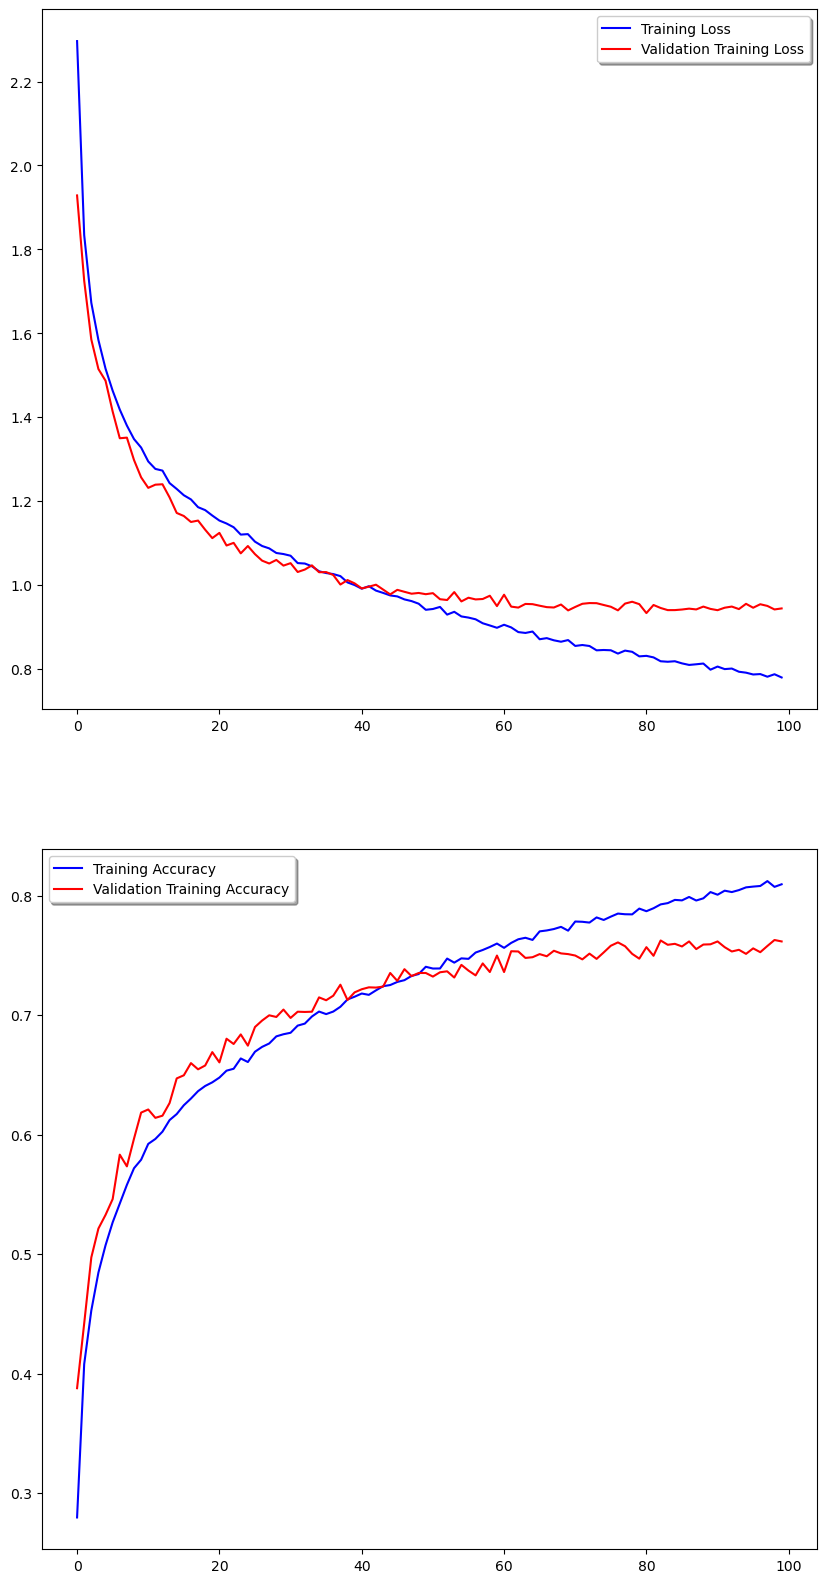

In [8]:
fig, ax = plt.subplots(2,1)
ax[0].plot(fit1.history['loss'], color='b', label="Training Loss")
ax[0].plot(fit1.history['val_loss'], color='r', label="Validation Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(fit1.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(fit1.history['val_acc'], color='r', label="Validation Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [9]:
score1 = best_model1.evaluate(x_test_nom, y_test_onehot, verbose = 0) 

print('Test loss:', score1[0]) 
print('Test accuracy:', score1[1])

2023-02-28 12:30:56.659897: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/AddN_1' id:266 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Test loss: 0.9708002155303955
Test accuracy: 0.7448


In [10]:
sample_no = 0

best_model1_no_softmax = innvestigate.model_wo_softmax(best_model1)

analyzer_gradient1 = innvestigate.create_analyzer("gradient", best_model1_no_softmax)
a1g = analyzer_gradient1.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a1g = a1g.sum(axis=np.argmax(np.asarray(a1g.shape) == 3))
a1g /= np.max(np.abs(a1g))

analyzer_gradient1 = innvestigate.create_analyzer("input_t_gradient", best_model1_no_softmax)
a1itg = analyzer_gradient1.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a1itg = a1itg.sum(axis=np.argmax(np.asarray(a1itg.shape) == 3))
a1itg /= np.max(np.abs(a1itg))

analyzer_gradient1 = innvestigate.create_analyzer("deep_taylor", best_model1_no_softmax)
a1dt = analyzer_gradient1.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a1dt = a1dt.sum(axis=np.argmax(np.asarray(a1dt.shape) == 3))
a1dt /= np.max(np.abs(a1dt))

analyzer_gradient1 = innvestigate.create_analyzer("integrated_gradients", best_model1_no_softmax)
a1ig = analyzer_gradient1.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a1ig = a1ig.sum(axis=np.argmax(np.asarray(a1ig.shape) == 3))
a1ig /= np.max(np.abs(a1ig))

analyzer_gradient1 = innvestigate.create_analyzer("lrp.z", best_model1_no_softmax)
a1lrpz = analyzer_gradient1.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a1lrpz = a1lrpz.sum(axis=np.argmax(np.asarray(a1lrpz.shape) == 3))
a1lrpz /= np.max(np.abs(a1lrpz))

analyzer_gradient1 = innvestigate.create_analyzer("lrp.epsilon", best_model1_no_softmax)
a1lrpe = analyzer_gradient1.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a1lrpe = a1lrpe.sum(axis=np.argmax(np.asarray(a1lrpe.shape) == 3))
a1lrpe /= np.max(np.abs(a1lrpe))

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", best_model1_no_softmax)
a1lrpa1b0 = analyzer_gradient1.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a1lrpa1b0 = a1lrpa1b0.sum(axis=np.argmax(np.asarray(a1lrpa1b0.shape) == 3))
a1lrpa1b0 /= np.max(np.abs(a1lrpe))

2023-02-28 12:30:57.900456: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d/Conv2D/ReadVariableOp' id:24 op device:{requested: '', assigned: ''} def:{{{node conv2d/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](conv2d/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:30:57.941455: W tensorflow/c/c_api.cc:291] Operation '{name:'bias/Assign' id:295 op device:{requested: '', assigned: ''} def:{{{node bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias, bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-0

2023-02-28 12:30:58.576806: W tensorflow/c/c_api.cc:291] Operation '{name:'keras_learning_phase' id:3 op device:{requested: '', assigned: ''} def:{{{node keras_learning_phase}} = PlaceholderWithDefault[_has_manual_control_dependencies=true, dtype=DT_BOOL, shape=[]](keras_learning_phase/input)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:30:58.625350: W tensorflow/c/c_api.cc:291] Operation '{name:'keras_learning_phase' id:3 op device:{requested: '', assigned: ''} def:{{{node keras_learning_phase}} = PlaceholderWithDefault[_has_manual_control_dependencies=true, dtype=DT_BOOL, shape=[]](keras_learning_phase/input)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a

2023-02-28 12:31:00.253522: W tensorflow/c/c_api.cc:291] Operation '{name:'MaxNeuronSelection_1/Max/reduction_indices' id:408 op device:{requested: '', assigned: ''} def:{{{node MaxNeuronSelection_1/Max/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:31:00.311062: W tensorflow/c/c_api.cc:291] Operation '{name:'ones_like_1/Const' id:411 op device:{requested: '', assigned: ''} def:{{{node ones_like_1/Const}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nod

2023-02-28 12:31:02.038556: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_2' id:557 op device:{requested: '', assigned: ''} def:{{{node mul_2}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](ReadVariableOp_15, Cast_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:31:02.117724: W tensorflow/c/c_api.cc:291] Operation '{name:'keras_learning_phase' id:3 op device:{requested: '', assigned: ''} def:{{{node keras_learning_phase}} = PlaceholderWithDefault[_has_manual_control_dependencies=true, dtype=DT_BOOL, shape=[]](keras_learning_phase/input)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:31:02.204298: W tensorflow/c/c_ap

2023-02-28 12:31:04.146991: W tensorflow/c/c_api.cc:291] Operation '{name:'dense/MatMul/ReadVariableOp' id:94 op device:{requested: '', assigned: ''} def:{{{node dense/MatMul/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](dense/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:31:04.219366: W tensorflow/c/c_api.cc:291] Operation '{name:'keras_learning_phase' id:3 op device:{requested: '', assigned: ''} def:{{{node keras_learning_phase}} = PlaceholderWithDefault[_has_manual_control_dependencies=true, dtype=DT_BOOL, shape=[]](keras_learning_phase/input)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

2023-02-28 12:31:07.014713: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_5' id:1265 op device:{requested: '', assigned: ''} def:{{{node Const_5}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:31:07.423605: W tensorflow/c/c_api.cc:291] Operation '{name:'reversed_kernel_conv2d_1/Conv2D/ReadVariableOp' id:1296 op device:{requested: '', assigned: ''} def:{{{node reversed_kernel_conv2d_1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](conv2d_1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

2023-02-28 12:31:11.573402: W tensorflow/c/c_api.cc:291] Operation '{name:'reversed_kernel_conv2d_2/Conv2D/ReadVariableOp' id:1570 op device:{requested: '', assigned: ''} def:{{{node reversed_kernel_conv2d_2/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](conv2d/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:31:11.766421: W tensorflow/c/c_api.cc:291] Operation '{name:'keras_learning_phase' id:3 op device:{requested: '', assigned: ''} def:{{{node keras_learning_phase}} = PlaceholderWithDefault[_has_manual_control_dependencies=true, dtype=DT_BOOL, shape=[]](keras_learning_phase/input)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after

2023-02-28 12:31:15.550486: W tensorflow/c/c_api.cc:291] Operation '{name:'keras_learning_phase' id:3 op device:{requested: '', assigned: ''} def:{{{node keras_learning_phase}} = PlaceholderWithDefault[_has_manual_control_dependencies=true, dtype=DT_BOOL, shape=[]](keras_learning_phase/input)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:31:15.722541: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_34/x' id:2000 op device:{requested: '', assigned: ''} def:{{{node mul_34/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-

Text(0.5, 0, 'LRP-alpha1-beta0')

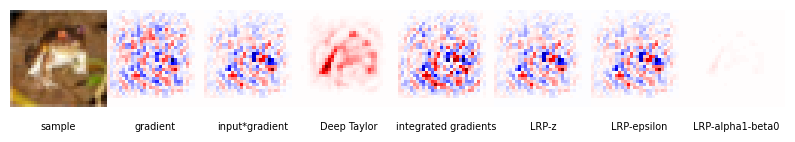

In [11]:
# Plot
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,8)
fig.subplots_adjust(hspace=0, wspace=0)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)      
ax[0].imshow(x_train_nom[sample_no])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].tick_params(left=False)
ax[0].tick_params(bottom=False)
#ax[0].axis('off')
ax[0].set_xlabel('sample', fontsize=7)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False) 
# ax[1].imshow(a1[0], cmap="seismic")
ax[1].imshow(a1g[0], cmap="seismic", clim=(-1, 1))
# ax[1].imshow(x_train_nom[sample_no])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(left=False)
ax[1].tick_params(bottom=False)
#ax[1].axis('off')
ax[1].set_xlabel('gradient', fontsize=7)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False) 
ax[2].imshow(a1itg[0], cmap="seismic", clim=(-1, 1))
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].tick_params(left=False)
ax[2].tick_params(bottom=False)
#ax[2].axis('off')
ax[2].set_xlabel('input*gradient', fontsize=7)

ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['left'].set_visible(False) 
ax[3].imshow(a1dt[0], cmap="seismic", clim=(-1, 1))
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].tick_params(left=False)
ax[3].tick_params(bottom=False)
#ax[3].axis('off')
ax[3].set_xlabel('Deep Taylor', fontsize=7)

ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].spines['bottom'].set_visible(False)
ax[4].spines['left'].set_visible(False) 
ax[4].imshow(a1ig[0], cmap="seismic", clim=(-1, 1))
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])
ax[4].tick_params(left=False)
ax[4].tick_params(bottom=False)
#ax[4].axis('off')
ax[4].set_xlabel('integrated gradients', fontsize=7)

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['bottom'].set_visible(False)
ax[5].spines['left'].set_visible(False) 
ax[5].imshow(a1lrpz[0], cmap="seismic", clim=(-1, 1))
ax[5].set_xticklabels([])
ax[5].set_yticklabels([])
ax[5].tick_params(left=False)
ax[5].tick_params(bottom=False)
#ax[5].axis('off')
ax[5].set_xlabel('LRP-z', fontsize=7)

ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].spines['bottom'].set_visible(False)
ax[6].spines['left'].set_visible(False)
ax[6].imshow(a1lrpe[0], cmap="seismic", clim=(-1, 1))
ax[6].set_xticklabels([])
ax[6].set_yticklabels([])
ax[6].tick_params(left=False)
ax[6].tick_params(bottom=False)
#ax[6].axis('off')
ax[6].set_xlabel('LRP-epsilon', fontsize=7)

ax[7].spines['top'].set_visible(False)
ax[7].spines['right'].set_visible(False)
ax[7].spines['bottom'].set_visible(False)
ax[7].spines['left'].set_visible(False)
ax[7].imshow(a1lrpa1b0[0], cmap="seismic", clim=(-1, 1))
ax[7].set_xticklabels([])
ax[7].set_yticklabels([])
ax[7].tick_params(left=False)
ax[7].tick_params(bottom=False)
#ax[7].axis('off')
ax[7].set_xlabel('LRP-alpha1-beta0', fontsize=7)

In [12]:
keras.backend.clear_session()

inputs = Input(shape=(32,32,3))
conv2d1 = Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),activation='relu', kernel_regularizer=l2(0.001))
conv2d2 = Conv2D(filters=32,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
dropout = Dropout(0.2)
conv2d3 = Conv2D(filters=64,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
conv2d4 = Conv2D(filters=64,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
conv2d3 = Conv2D(filters=128,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
conv2d4 = Conv2D(filters=128,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
flatten = Flatten()
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))
dense2 = Dense(10, activation='softmax')

x = conv2d1(inputs)
x = maxpool2d(x)
x = dropout(x)
x = conv2d2(x)
x = maxpool2d(x)
x = dropout(x)
x = flatten(x)
x = dense1(x)
x = dropout(x)
x = dense2(x)

model2 = keras.Model(inputs=inputs, outputs=x) 

mod_h5_2 = 'CIFAR10_model_2.h5'

checkpoint = ModelCheckpoint(mod_h5_2, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model2.compile(optimizer='adam',
            loss='categorical_crossentropy', metrics=['acc'])
fit2 = model2.fit(x_train_nom, y_train_onehot,
            batch_size=1000,
            epochs=100, 
            shuffle=True,
            validation_split = 0.1, 
            callbacks=callbacks)  

Train on 45000 samples, validate on 5000 samples
Epoch 1/100


2023-02-28 12:31:19.918381: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/learning_rate/Assign' id:365 op device:{requested: '', assigned: ''} def:{{{node training/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/learning_rate, training/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


45000/45000 [==============================] - ETA: 0s - loss: 2.2600 - acc: 0.2320

2023-02-28 12:31:26.436421: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/AddN_1' id:233 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_loss improved from inf to 1.98332, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 154us/sample - loss: 2.2600 - acc: 0.2320 - val_loss: 1.9833 - val_acc: 0.3552
Epoch 2/100
45000/45000 [==============================] - ETA: 0s - loss: 1.8679 - acc: 0.3713
Epoch 2: val_loss improved from 1.98332 to 1.73911, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 153us/sample - loss: 1.8679 - acc: 0.3713 - val_loss: 1.7391 - val_acc: 0.4226
Epoch 3/100
45000/45000 [==============================] - ETA: 0s - loss: 1.7163 - acc: 0.4240
Epoch 3: val_loss improved from 1.73911 to 1.62514, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 155us/sample - loss: 1.7163 - acc: 0.4240 - val_loss: 1.6251 - val_acc: 0.4594
Epoch 4/100
45000/45000 [==============================] - ETA: 0s - loss: 1.6310 - acc: 0.4544
Epoch 4: val_loss improved from 1.62514 to 1.55547, saving model to

Epoch 28/100
45000/45000 [==============================] - ETA: 0s - loss: 1.1606 - acc: 0.6377
Epoch 28: val_loss improved from 1.11786 to 1.10250, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 152us/sample - loss: 1.1606 - acc: 0.6377 - val_loss: 1.1025 - val_acc: 0.6728
Epoch 29/100
45000/45000 [==============================] - ETA: 0s - loss: 1.1579 - acc: 0.6363
Epoch 29: val_loss did not improve from 1.10250
45000/45000 [==============================] - 7s 152us/sample - loss: 1.1579 - acc: 0.6363 - val_loss: 1.1025 - val_acc: 0.6758
Epoch 30/100
45000/45000 [==============================] - ETA: 0s - loss: 1.1478 - acc: 0.6441
Epoch 30: val_loss improved from 1.10250 to 1.09797, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 151us/sample - loss: 1.1478 - acc: 0.6441 - val_loss: 1.0980 - val_acc: 0.6742
Epoch 31/100
45000/45000 [==============================] - ETA: 0s - loss: 1.1449 - acc: 0.6474
E

45000/45000 [==============================] - 7s 151us/sample - loss: 1.0184 - acc: 0.6977 - val_loss: 0.9986 - val_acc: 0.7088
Epoch 56/100
45000/45000 [==============================] - ETA: 0s - loss: 1.0170 - acc: 0.6979
Epoch 56: val_loss improved from 0.99513 to 0.98762, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 151us/sample - loss: 1.0170 - acc: 0.6979 - val_loss: 0.9876 - val_acc: 0.7132
Epoch 57/100
45000/45000 [==============================] - ETA: 0s - loss: 1.0079 - acc: 0.7025
Epoch 57: val_loss improved from 0.98762 to 0.98459, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 155us/sample - loss: 1.0079 - acc: 0.7025 - val_loss: 0.9846 - val_acc: 0.7128
Epoch 58/100
45000/45000 [==============================] - ETA: 0s - loss: 1.0028 - acc: 0.7039
Epoch 58: val_loss did not improve from 0.98459
45000/45000 [==============================] - 7s 151us/sample - loss: 1.0028 - acc: 0.7039 - val_

Epoch 84/100
45000/45000 [==============================] - ETA: 0s - loss: 0.9296 - acc: 0.7333
Epoch 84: val_loss improved from 0.94711 to 0.94572, saving model to CIFAR10_model_2.h5
45000/45000 [==============================] - 7s 152us/sample - loss: 0.9296 - acc: 0.7333 - val_loss: 0.9457 - val_acc: 0.7308
Epoch 85/100
45000/45000 [==============================] - ETA: 0s - loss: 0.9234 - acc: 0.7342
Epoch 85: val_loss did not improve from 0.94572
45000/45000 [==============================] - 7s 149us/sample - loss: 0.9234 - acc: 0.7342 - val_loss: 0.9635 - val_acc: 0.7268
Epoch 86/100
45000/45000 [==============================] - ETA: 0s - loss: 0.9330 - acc: 0.7291
Epoch 86: val_loss did not improve from 0.94572
45000/45000 [==============================] - 7s 147us/sample - loss: 0.9330 - acc: 0.7291 - val_loss: 0.9532 - val_acc: 0.7250
Epoch 87/100
45000/45000 [==============================] - ETA: 0s - loss: 0.9230 - acc: 0.7328
Epoch 87: val_loss did not improve from 0

In [13]:
keras.backend.clear_session()

inputs = Input(shape=(32,32,3))
conv2d1 = Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),activation='relu', kernel_regularizer=l2(0.001))
conv2d2 = Conv2D(filters=32,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
dropout = Dropout(0.2)
conv2d3 = Conv2D(filters=64,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
conv2d4 = Conv2D(filters=64,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
conv2d3 = Conv2D(filters=128,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
conv2d4 = Conv2D(filters=128,kernel_size=(3,3),activation='relu', kernel_regularizer=l2(0.001))
maxpool2d = MaxPooling2D(pool_size=(2,2))
flatten = Flatten()
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))
dense2 = Dense(10, activation='softmax')

x = conv2d1(inputs)
x = maxpool2d(x)
x = dropout(x)
x = conv2d2(x)
x = maxpool2d(x)
x = dropout(x)
x = flatten(x)
x = dense1(x)
x = dropout(x)
x = dense2(x)

best_model2 = keras.Model(inputs=inputs, outputs=x) 
best_model2.load_weights(mod_h5_2)
best_model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

y_test_pred2 = best_model2.predict(x_test_nom)

2023-02-28 12:42:43.641995: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1/bias/Assign' id:125 op device:{requested: '', assigned: ''} def:{{{node dense_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1/bias, dense_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:43.784454: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1/Softmax' id:131 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-

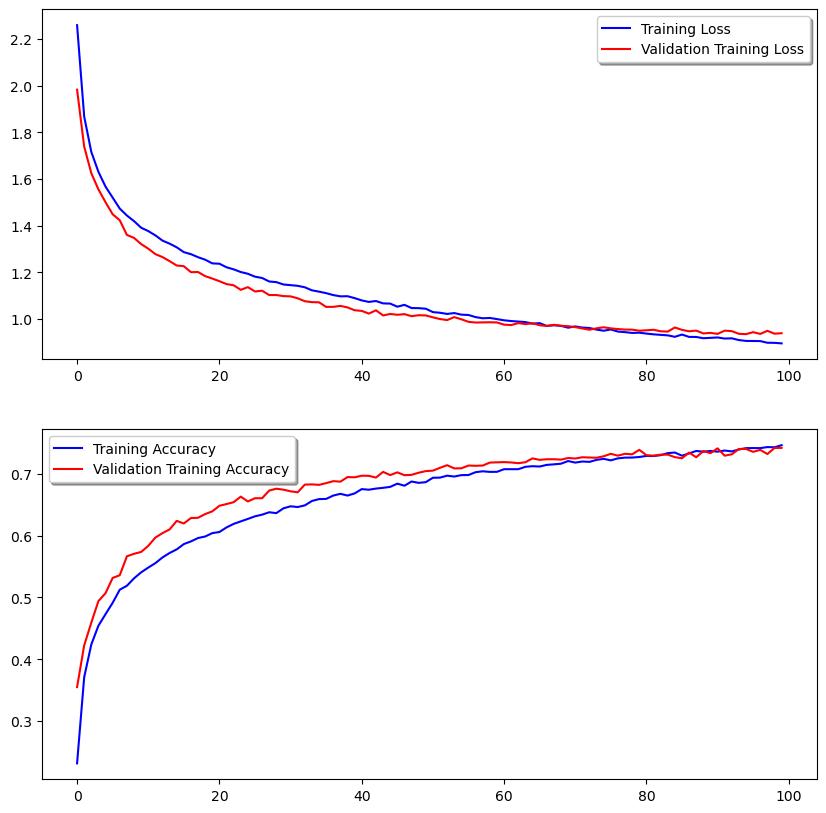

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(fit2.history['loss'], color='b', label="Training Loss")
ax[0].plot(fit2.history['val_loss'], color='r', label="Validation Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(fit2.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(fit2.history['val_acc'], color='r', label="Validation Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [15]:
score2 = best_model2.evaluate(x_test_nom, y_test_onehot, verbose = 0) 

print('Test loss:', score2[0]) 
print('Test accuracy:', score2[1])

2023-02-28 12:42:45.297181: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/AddN_1' id:266 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Test loss: 0.9607593044281005
Test accuracy: 0.7279


In [16]:
sample_no = 0

best_model2_no_softmax = innvestigate.model_wo_softmax(best_model2)

analyzer_gradient2 = innvestigate.create_analyzer("gradient", best_model2_no_softmax)
a2g = analyzer_gradient2.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a2g = a2g.sum(axis=np.argmax(np.asarray(a2g.shape) == 3))
a2g /= np.max(np.abs(a2g))

analyzer_gradient2 = innvestigate.create_analyzer("input_t_gradient", best_model2_no_softmax)
a2itg = analyzer_gradient2.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a2itg = a2itg.sum(axis=np.argmax(np.asarray(a2itg.shape) == 3))
a2itg /= np.max(np.abs(a2itg))

analyzer_gradient2 = innvestigate.create_analyzer("deep_taylor", best_model2_no_softmax)
a2dt = analyzer_gradient2.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a2dt = a2dt.sum(axis=np.argmax(np.asarray(a2dt.shape) == 3))
a2dt /= np.max(np.abs(a2dt))

analyzer_gradient2 = innvestigate.create_analyzer("integrated_gradients", best_model2_no_softmax)
a2ig = analyzer_gradient2.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a2ig = a2ig.sum(axis=np.argmax(np.asarray(a2ig.shape) == 3))
a2ig /= np.max(np.abs(a2ig))

analyzer_gradient2 = innvestigate.create_analyzer("lrp.z", best_model2_no_softmax)
a2lrpz = analyzer_gradient2.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a2lrpz = a2lrpz.sum(axis=np.argmax(np.asarray(a2lrpz.shape) == 3))
a2lrpz /= np.max(np.abs(a2lrpz))

analyzer_gradient2 = innvestigate.create_analyzer("lrp.epsilon", best_model2_no_softmax)
a2lrpe = analyzer_gradient2.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a2lrpe = a2lrpe.sum(axis=np.argmax(np.asarray(a2lrpe.shape) == 3))
a2lrpe /= np.max(np.abs(a2lrpe))

analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", best_model2_no_softmax)
a2lrpa1b0 = analyzer_gradient2.analyze(x_train_nom[sample_no][np.newaxis,:])

# Aggregate along color channels and normalize to [-1, 1]
a2lrpa1b0 = a2lrpa1b0.sum(axis=np.argmax(np.asarray(a2lrpa1b0.shape) == 3))
a2lrpa1b0 /= np.max(np.abs(a2lrpa1b0))

2023-02-28 12:42:46.697320: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d/Conv2D/ReadVariableOp' id:24 op device:{requested: '', assigned: ''} def:{{{node conv2d/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](conv2d/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:46.744081: W tensorflow/c/c_api.cc:291] Operation '{name:'bias/Assign' id:295 op device:{requested: '', assigned: ''} def:{{{node bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias, bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-0

2023-02-28 12:42:47.964885: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d/Conv2D/ReadVariableOp' id:24 op device:{requested: '', assigned: ''} def:{{{node conv2d/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](conv2d/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:48.021310: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d/Conv2D/ReadVariableOp' id:24 op device:{requested: '', assigned: ''} def:{{{node conv2d/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](conv2d/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 1

2023-02-28 12:42:49.500038: W tensorflow/c/c_api.cc:291] Operation '{name:'MaxNeuronSelection_2/Max/reduction_indices' id:510 op device:{requested: '', assigned: ''} def:{{{node MaxNeuronSelection_2/Max/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:49.551961: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_8/x' id:709 op device:{requested: '', assigned: ''} def:{{{node mul_8/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running

2023-02-28 12:42:50.923040: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_3' id:855 op device:{requested: '', assigned: ''} def:{{{node Const_3}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:50.990682: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_1' id:523 op device:{requested: '', assigned: ''} def:{{{node mul_1}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](ReadVariableOp_13, Cast_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:51.056742: W tensorflow/c/c_api.cc:291] Operation '{name:'m

2023-02-28 12:42:53.888657: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_49/MaxNeuronSelection_3/Max_grad/mod' id:1202 op device:{requested: '', assigned: ''} def:{{{node gradients_49/MaxNeuronSelection_3/Max_grad/mod}} = FloorMod[T=DT_INT32, _class=["loc:@MaxNeuronSelection_3/Max"], _has_manual_control_dependencies=true](gradients_49/MaxNeuronSelection_3/Max_grad/add, gradients_49/MaxNeuronSelection_3/Max_grad/Size)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:53.993823: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_49/MaxNeuronSelection_3/Max_grad/ones' id:1208 op device:{requested: '', assigned: ''} def:{{{node gradients_49/MaxNeuronSelection_3/Max_grad/ones}} = Fill[T=DT_INT32, _class=["loc:@MaxNeuronSelection_3/Max"], _has_manual_control_dependencies=true, index_type=DT_INT32]

2023-02-28 12:42:56.801451: W tensorflow/c/c_api.cc:291] Operation '{name:'bias_5/Assign' id:1373 op device:{requested: '', assigned: ''} def:{{{node bias_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_5, bias_5/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:42:57.001386: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_60/MaxNeuronSelection_4/Max_grad/range' id:1440 op device:{requested: '', assigned: ''} def:{{{node gradients_60/MaxNeuronSelection_4/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_4/Max"], _has_manual_control_dependencies=true](gradients_60/MaxNeuronSelection_4/Max_grad/range/start, gradients_60/MaxNeuronSelection_4/Max_grad/Size, gradients_60/MaxNeuronSelection_4/Max_grad/ran

2023-02-28 12:43:01.361398: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_32/x' id:1883 op device:{requested: '', assigned: ''} def:{{{node mul_32/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:43:01.525575: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_8' id:1880 op device:{requested: '', assigned: ''} def:{{{node Const_8}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:43:01.689679: W tensor

2023-02-28 12:43:05.055063: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_35/x' id:2052 op device:{requested: '', assigned: ''} def:{{{node mul_35/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:43:05.231785: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_11' id:2049 op device:{requested: '', assigned: ''} def:{{{node Const_11}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-28 12:43:05.413187: W tens

Text(0.5, 0, 'LRP-alpha1-beta0')

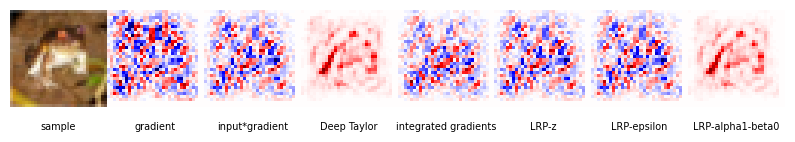

In [17]:
# Plot
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,8)
fig.subplots_adjust(hspace=0, wspace=0)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)      
ax[0].imshow(x_train_nom[sample_no])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].tick_params(left=False)
ax[0].tick_params(bottom=False)
#ax[0].axis('off')
ax[0].set_xlabel('sample', fontsize=7)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False) 
# ax[1].imshow(a2[0], cmap="seismic")
ax[1].imshow(a2g[0], cmap="seismic", clim=(-1, 1))
# ax[1].imshow(x_train_nom[sample_no])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(left=False)
ax[1].tick_params(bottom=False)
#ax[1].axis('off')
ax[1].set_xlabel('gradient', fontsize=7)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False) 
ax[2].imshow(a2itg[0], cmap="seismic", clim=(-1, 1))
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].tick_params(left=False)
ax[2].tick_params(bottom=False)
#ax[2].axis('off')
ax[2].set_xlabel('input*gradient', fontsize=7)

ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['left'].set_visible(False) 
ax[3].imshow(a2dt[0], cmap="seismic", clim=(-1, 1))
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].tick_params(left=False)
ax[3].tick_params(bottom=False)
#ax[3].axis('off')
ax[3].set_xlabel('Deep Taylor', fontsize=7)

ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].spines['bottom'].set_visible(False)
ax[4].spines['left'].set_visible(False) 
ax[4].imshow(a2ig[0], cmap="seismic", clim=(-1, 1))
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])
ax[4].tick_params(left=False)
ax[4].tick_params(bottom=False)
#ax[4].axis('off')
ax[4].set_xlabel('integrated gradients', fontsize=7)

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['bottom'].set_visible(False)
ax[5].spines['left'].set_visible(False) 
ax[5].imshow(a2lrpz[0], cmap="seismic", clim=(-1, 1))
ax[5].set_xticklabels([])
ax[5].set_yticklabels([])
ax[5].tick_params(left=False)
ax[5].tick_params(bottom=False)
#ax[5].axis('off')
ax[5].set_xlabel('LRP-z', fontsize=7)

ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].spines['bottom'].set_visible(False)
ax[6].spines['left'].set_visible(False)
ax[6].imshow(a2lrpe[0], cmap="seismic", clim=(-1, 1))
ax[6].set_xticklabels([])
ax[6].set_yticklabels([])
ax[6].tick_params(left=False)
ax[6].tick_params(bottom=False)
#ax[6].axis('off')
ax[6].set_xlabel('LRP-epsilon', fontsize=7)

ax[7].spines['top'].set_visible(False)
ax[7].spines['right'].set_visible(False)
ax[7].spines['bottom'].set_visible(False)
ax[7].spines['left'].set_visible(False)
ax[7].imshow(a2lrpa1b0[0], cmap="seismic", clim=(-1, 1))
ax[7].set_xticklabels([])
ax[7].set_yticklabels([])
ax[7].tick_params(left=False)
ax[7].tick_params(bottom=False)
#ax[7].axis('off')
ax[7].set_xlabel('LRP-alpha1-beta0', fontsize=7)